## LLMOps - Data Preparation

In [18]:
## Importing all the necessaries libraries
import pandas as pd
import datetime
import vertexai
from sklearn.model_selection import train_test_split
from google.oauth2 import service_account
from google.cloud import bigquery
from utils import authenticate

In [4]:
# Load credentials
credentials, PROJECT_ID = authenticate()
REGION = "us-central1"

In [3]:
vertexai.init(project = PROJECT_ID,
              location = REGION,
              credentials = credentials)

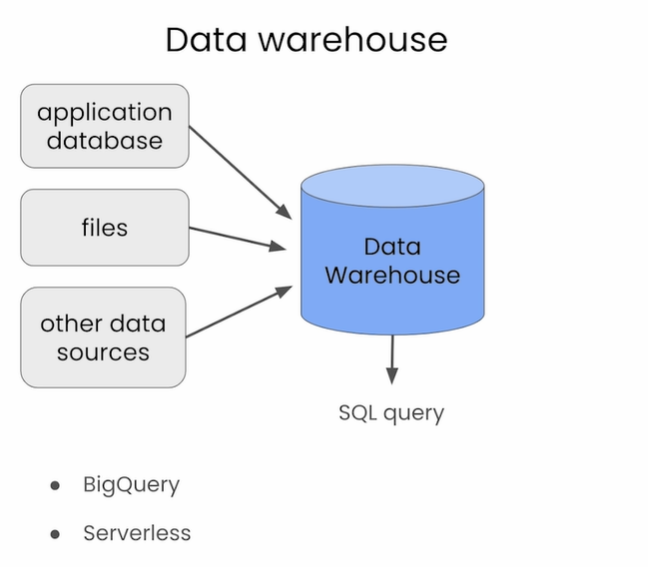

In [5]:
# Using the BigQuery API as Data Warehouse to load the data
bq_client = bigquery.Client(project = PROJECT_ID,
                            credentials = credentials)

### retrieving data from **Stack Overflow** public dataset
The datasets include questions, answers and metadata related to Stack Overflow questions.

In [7]:
# Asking to retrieve table_name of all the TABLES
QUERY_TABLES = """
SELECT
  table_name
FROM
  `bigquery-public-data.stackoverflow.INFORMATION_SCHEMA.TABLES`
"""
query_job = bq_client.query(QUERY_TABLES)

In [8]:
# Printing all available tables
for row in query_job:
    for value in row.values():
        print(value)

posts_answers
users
posts_orphaned_tag_wiki
posts_tag_wiki
stackoverflow_posts
posts_questions
comments
posts_tag_wiki_excerpt
posts_wiki_placeholder
posts_privilege_wiki
post_history
badges
post_links
tags
votes
posts_moderator_nomination


### Data Retrieval
Fetching data from the data warehouse and storing into Pandas dataframe

In [9]:
INSPECT_QUERY = """
SELECT
    *
FROM
    `bigquery-public-data.stackoverflow.posts_questions`
LIMIT 3
"""
query_job = bq_client.query(INSPECT_QUERY)

stack_overflow_df = query_job\
    .result()\
    .to_arrow()\
    .to_pandas()
stack_overflow_df.head()

,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags,view_count
0,73210679,az acr login raises DOCKER_COMMAND_ERROR with ...,<p>Windows 11 with wsl2 ubuntu-22.04.</p>\n<p>...,73247188.0,1,0,NaT,2022-08-02 16:16:31.810000+00:00,NaN,2022-08-05 09:00:14.693000+00:00,2022-08-02 16:32:13.700000+00:00,None,11226740,None,11226740,None,1,0,azure-container-registry|docker-daemon,256
1,73284406,Run Azure log query from the command line with...,<p>I am trying to get the Azure log query data...,NaN,2,0,NaT,2022-08-08 21:53:16.703000+00:00,NaN,2022-08-10 04:49:20.527000+00:00,2022-08-09 08:12:13.920000+00:00,None,2395282,None,19123691,None,1,0,azure|azure-devops|azure-application-insights|...,256
2,73250763,Error CS0246: The type or namespace name 'Stre...,<p>I have these errors when trying to write th...,73251390.0,1,0,NaT,2022-08-05 13:43:25.850000+00:00,NaN,2022-08-05 16:40:00.610000+00:00,2022-08-05 16:40:00.610000+00:00,None,17654458,None,17654458,None,1,3,c#|unity3d,512


### Dealing with Large Datasets
Large datasets for LLMs often don't fit into memory.

In [10]:
QUERY_ALL = """
SELECT
    *
FROM
    `bigquery-public-data.stackoverflow.posts_questions` q
"""
query_job = bq_client.query(QUERY_ALL)

try:
    stack_overflow_df = query_job\
    .result()\
    .to_arrow()\
    .to_pandas()
except Exception as e:
    print('The DataFrame is too large to load into memory.', e)

The DataFrame is too large to load into memory. 403 Response too large to return. Consider specifying a destination table in your job configuration. For more details, see https://cloud.google.com/bigquery/troubleshooting-errors

Location: US
Job ID: 5840c726-3f2e-4931-8f5d-e53df414c5cf



#### Joining Tables and Query Optimization

- When working with (large) data, query optimizing is needed in order to save time and resources.
- Select questions as `input_text` (column 1), answers as `output_text` (column 2).
- Take the questions from `posts_questions` and answers from `posts_answers`.
- Join the questions and their corresponding accepted answers based on their same `unique ID`.
- Making sure the question is about `Python`, and that it `has an answer`. And the date the question was posted is on or after `2020-01-01`
- Limit as 10,000

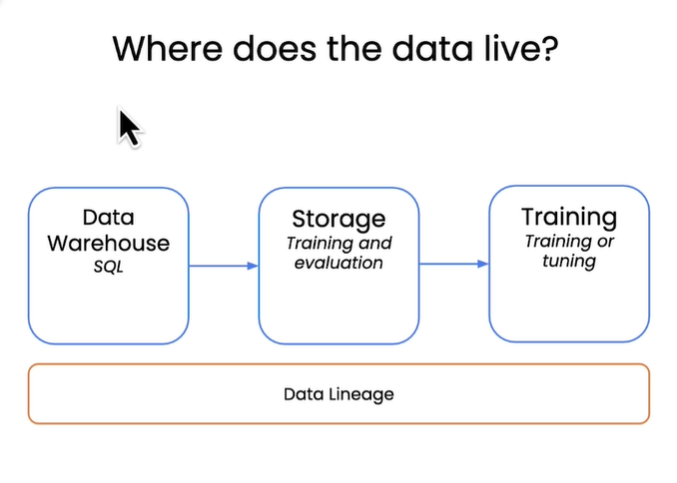

In [11]:
QUERY = """
SELECT
    CONCAT(q.title, q.body) as input_text,
    a.body AS output_text
FROM
    `bigquery-public-data.stackoverflow.posts_questions` q
JOIN
    `bigquery-public-data.stackoverflow.posts_answers` a
ON
    q.accepted_answer_id = a.id
WHERE
    q.accepted_answer_id IS NOT NULL AND
    REGEXP_CONTAINS(q.tags, "python") AND
    a.creation_date >= "2020-01-01"
LIMIT
    10000
"""

query_job = bq_client.query(QUERY)


stack_overflow_df = query_job.result()\
                        .to_arrow()\
                        .to_pandas()

stack_overflow_df.head(2)

,input_text,output_text
0,Transformation of Pandas Dataframe from long t...,"<p>Use <a href=""https://pandas.pydata.org/docs..."
1,Compare ndarray item with lower case string<p>...,<p>Create new array with lower case</p>\n<pre>...


### Adding Instructions

- Instructions for LLMs have been shown to improve
model performance and generalization to unseen tasks [(Google, 2022)](https://arxiv.org/pdf/2210.11416.pdf).
- Wihtout the instruction, it is only question and answer. Model might not understand what to do.
- With the instructions, the model gets a guideline as to what task to perform.

In [12]:
INSTRUCTION_TEMPLATE = f"""\
Please answer the following Stackoverflow question on Python. \
Answer it like you are a developer answering Stackoverflow questions.

Stackoverflow question:
"""

In [13]:
stack_overflow_df['input_text_instruct'] = INSTRUCTION_TEMPLATE + ' '\
    + stack_overflow_df['input_text']

### Dataset for Tuning

- Divide the data into a training and evaluation. By default, 80/20 split is used.
- This (80/20 split) allows for more data to be used for tuning. The evaluation split is used as unseen data during tuning to evaluate performance.
- The `random_state` parameter is used to ensure random sampling for a fair comparison. 

In [15]:
train, evaluation = train_test_split(
    stack_overflow_df,
    test_size=0.2,
    random_state=42
)

#### Versioning data
It allows for reproducibility, traceability, and maintainability of machine learning models.


In [23]:
date = datetime.datetime.now().strftime("%H-%d-%m-%Y")

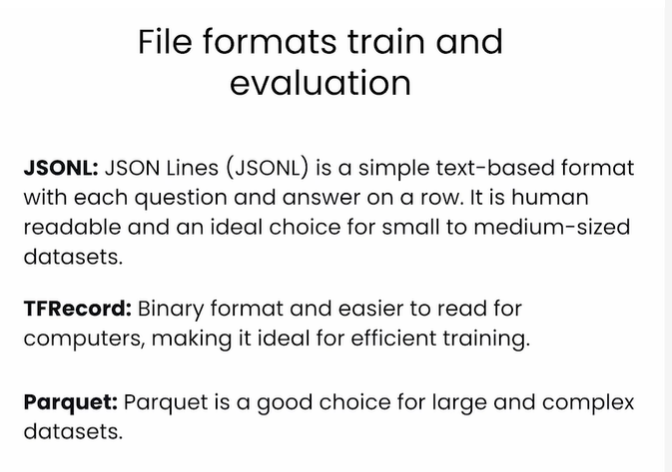

In [24]:
cols = ['input_text_instruct','output_text']
tune_jsonl = train[cols].to_json(orient="records", lines=True)

In [34]:
training_data_filename = f"tune_data_stack_overflow_python_qa-{date}.jsonl"
training_path = f"data/{training_data_filename}"

In [35]:
with open(training_path, "w") as f:
    f.write(tune_jsonl)

## Evaluation Set

In [36]:
cols = ['input_text_instruct','output_text']
### you need to use the "evaluation" set now
tune_jsonl = evaluation[cols].to_json(orient="records", lines=True)

### change the file name
### use "tune_eval_data_stack_overflow_python_qa-{date}.jsonl"
evaluation_data_filename = f"tune_eval_data_stack_overflow_python_qa-{date}.jsonl"
evaluation_path = f"data/{evaluation_data_filename}"
### write the file
with open(evaluation_path, "w") as f:
    f.write(tune_jsonl)